In [33]:
import time
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression

import matplotlib.pyplot as plt
from matplotlib.patches import Circle

from pylablib.devices import Thorlabs

from LinearStage import LinearStage

In [2]:
Thorlabs.list_cameras_tlcam()

['32756']

In [ ]:
cam = Thorlabs.ThorlabsTLCamera(serial="32756")
cam.set_roi(0, 1440, 0, 1080, 1, 1)

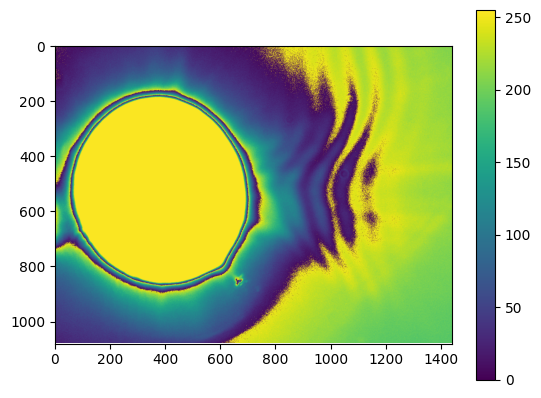

In [ ]:
frame = cam.snap()
image_array = np.array(frame, dtype=np.uint8)
plt.imshow(image_array)
plt.colorbar()

In [ ]:
ls = LinearStage()
lls = ls.find_devices()
print(lls)
info = ls.connect(lls[0])
print(info)


['COM4']
Status is a dictionary.
COM4, address 0: ELL20 	(S/N: 12000020)
Status is a dictionary.
Status OK (position)
{'Address': '0', 'Motor Type': 20, 'Serial No.': '12000020', 'Year': '2024', 'Firmware': '14', 'Thread': None, 'Hardware': '1', 'Range': 60, 'Pulse/Rev': 1024}


In [10]:
columns = ['position', 'image']
measurements_df = pd.DataFrame(columns=columns)

In [ ]:
for pos in range(0, 47, 1):
    curr_pos = ls.move(pos)
    print(curr_pos)

    frame = cam.snap()
    image_array = np.array(frame, dtype=np.uint8)
    
    # Append to DataFrame
    new_row = pd.DataFrame({
        'position': [curr_pos],
        'image': [image_array]
    })
    measurements_df = pd.concat([measurements_df, new_row], ignore_index=True)

    # plt.imshow(image_array)
    # plt.colorbar()
    # plt.title(curr_pos)
    # plt.show()

    time.sleep(0.2)

C:\Users\vrutckaia\AppData\Local\Temp\ipykernel_10740\72278849.py:13: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  measurements_df = pd.concat([measurements_df, new_row], ignore_index=True)


In [6]:
import joblib
measurements_df = joblib.load('./data/z_stage/z_stage_df.joblib')

In [7]:
measurements_df.head()

,position,image,center_x,center_y,radius,major_axis,minor_axis,angle
0,0.0020,"[[14, 2, 4, 2, 254, 252, 6, 10, 254, 1, 9, 3, ...",819.419067,479.020386,649.928101,647.326782,652.529419,145.896835
1,1.0029,"[[10, 253, 0, 254, 4, 254, 4, 7, 252, 255, 5, ...",814.030945,477.819061,642.517456,639.875305,645.159607,144.934799
2,2.0010,"[[9, 5, 253, 254, 250, 2, 250, 2, 1, 252, 6, 1...",805.098022,481.942139,635.535858,632.588196,638.483521,149.315704
3,2.9971,"[[12, 7, 249, 254, 3, 8, 4, 8, 255, 254, 3, 2,...",796.985352,482.046112,628.273407,625.303528,631.243286,149.662613
4,3.9971,"[[8, 248, 8, 249, 251, 249, 251, 0, 253, 254, ...",787.297913,483.573425,621.055115,617.745605,624.364624,150.717651


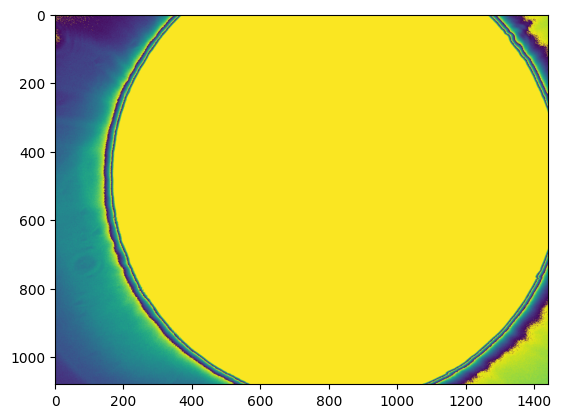

In [8]:
for i, row in measurements_df.iterrows():
    image = row['image']
    plt.imshow(image)
    plt.show()
    break

In [19]:
def normalize_images_to_max(df):
    # Create a new column for normalized images
    df['image_normalized'] = None
    
    # Process each image
    for idx, row in df.iterrows():
        image = row['image']
        
        normalized_image = np.maximum(image, 240)
        
        # Store normalized image in DataFrame
        df.at[idx, 'image_normalized'] = normalized_image
    
    return df

In [20]:
measurements_df = normalize_images_to_max(measurements_df)

In [21]:
import cv2
import numpy as np
import pandas as pd

def estimate_beam_parameters(image):
    # Convert image to grayscale if it isn't already
    if len(image.shape) == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    else:
        gray = image
    
    # Apply threshold to isolate the bright beam (adjust threshold as needed)
    _, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    # Find contours
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    if len(contours) == 0:
        return None  # No beam found
    
    # Get the largest contour (assumed to be the beam)
    largest_contour = max(contours, key=cv2.contourArea)
    
    # Fit an ellipse to the contour
    if len(largest_contour) >= 5:  # Need at least 5 points to fit an ellipse
        ellipse = cv2.fitEllipse(largest_contour)
        (center_x, center_y), (major_axis, minor_axis), angle = ellipse
        
        # Calculate radius (average of major and minor axes for approximation)
        radius = (major_axis + minor_axis) / 4.0  # Divide by 2 to get radius, then average
        
        return {
            'center_x': center_x,
            'center_y': center_y,
            'radius': radius,
            'major_axis': major_axis / 2.0,
            'minor_axis': minor_axis / 2.0,
            'angle': angle
        }
    else:
        return None  # Not enough points to fit ellipse

# Process all images in the DataFrame
def process_images(df):
    # Initialize new columns for parameters
    df['center_x'] = np.nan
    df['center_y'] = np.nan
    df['radius'] = np.nan
    df['major_axis'] = np.nan
    df['minor_axis'] = np.nan
    df['angle'] = np.nan
    
    # Process each image
    for idx, row in df.iterrows():
        # params = estimate_beam_parameters(row['image'])
        params = estimate_beam_parameters(row['image_normalized'])
        if params:
            df.at[idx, 'center_x'] = params['center_x']
            df.at[idx, 'center_y'] = params['center_y']
            df.at[idx, 'radius'] = params['radius']
            df.at[idx, 'major_axis'] = params['major_axis']
            df.at[idx, 'minor_axis'] = params['minor_axis']
            df.at[idx, 'angle'] = params['angle']
    
    return df

In [22]:
measurements_df = process_images(measurements_df)
measurements_df.head()

,position,image,center_x,center_y,radius,major_axis,minor_axis,angle,image_normalized
0,0.0020,"[[14, 2, 4, 2, 254, 252, 6, 10, 254, 1, 9, 3, ...",819.419067,479.020386,649.928101,647.326782,652.529419,145.896835,"[[240, 240, 240, 240, 254, 252, 240, 240, 254,..."
1,1.0029,"[[10, 253, 0, 254, 4, 254, 4, 7, 252, 255, 5, ...",814.030945,477.819061,642.517456,639.875305,645.159607,144.934799,"[[240, 253, 240, 254, 240, 254, 240, 240, 252,..."
2,2.0010,"[[9, 5, 253, 254, 250, 2, 250, 2, 1, 252, 6, 1...",805.098022,481.942139,635.535858,632.588196,638.483521,149.315704,"[[240, 240, 253, 254, 250, 240, 250, 240, 240,..."
3,2.9971,"[[12, 7, 249, 254, 3, 8, 4, 8, 255, 254, 3, 2,...",796.985352,482.046112,628.273407,625.303528,631.243286,149.662613,"[[240, 240, 249, 254, 240, 240, 240, 240, 255,..."
4,3.9971,"[[8, 248, 8, 249, 251, 249, 251, 0, 253, 254, ...",787.297913,483.573425,621.055115,617.745605,624.364624,150.717651,"[[240, 248, 240, 249, 251, 249, 251, 240, 253,..."


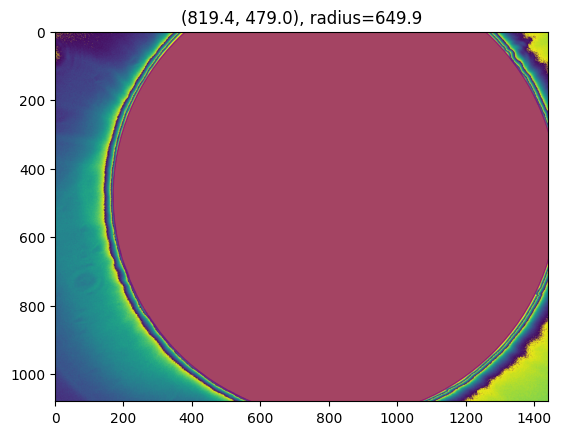

In [28]:
for i, row in measurements_df.iterrows():
    fig, ax = plt.subplots()
    image = row['image']  # Use the original image
    # image = row['image_normalized']
    center_x = row['center_x']
    center_y = row['center_y']
    radius = row['radius']

    circle = Circle((center_x, center_y), radius, color='purple', alpha=0.7)

    ax.add_patch(circle)
    plt.imshow(image)
    plt.title(f"({center_x:.1f}, {center_y:.1f}), radius={radius:.1f}")
    plt.show()
    break

In [ ]:
df = measurements_df#[:-25]

# convert center and radius to mm, pixel size is 3.45um
df['center_x_mm'] = df['center_x'] * 3.45e-3
df['center_y_mm'] = df['center_y'] * 3.45e-3
df['radius_mm'] = df['radius'] * 3.45e-3

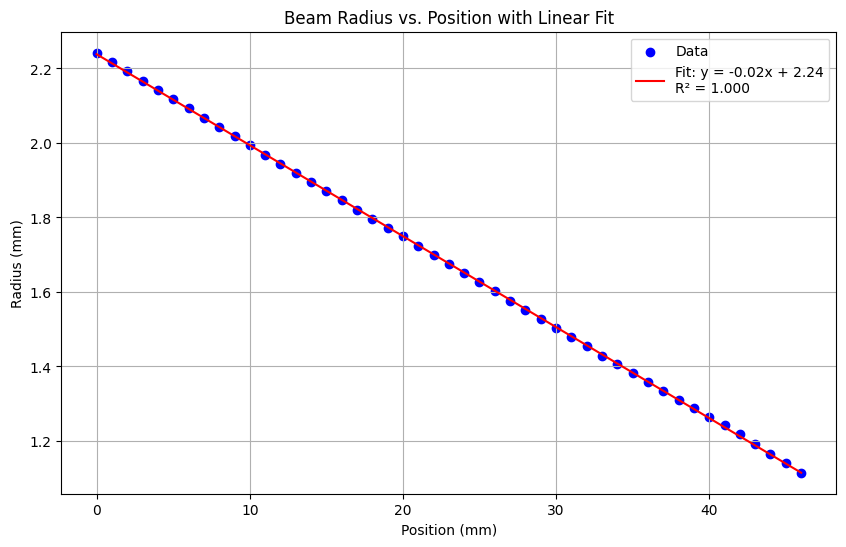

Slope: -0.02


In [36]:


X = df['position'].values.reshape(-1, 1)  # Reshape for sklearn
y = df['radius_mm'].values

# Fit linear model
model = LinearRegression()
model.fit(X, y)

# Get slope and intercept
slope = model.coef_[0]
intercept = model.intercept_

# Generate points for the fitted line
x_fit = np.linspace(X.min(), X.max(), 100).reshape(-1, 1)
y_fit = model.predict(x_fit)

# Calculate R-squared
r_squared = model.score(X, y)

# Create scatter plot with fitted line
plt.figure(figsize=(10, 6))
plt.scatter(df['position'], df['radius_mm'], color='blue', label='Data')
plt.plot(x_fit, y_fit, color='red', label=f'Fit: y = {slope:.2f}x + {intercept:.2f}\nR² = {r_squared:.3f}')

# Add labels and title
plt.xlabel('Position (mm)')
plt.ylabel('Radius (mm)')
plt.title('Beam Radius vs. Position with Linear Fit')
plt.grid(True)
plt.legend()

# Show the plot
plt.show()

print(f"Slope: {slope:.2f}")